In [1]:
import argparse, pydicom
import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, Dict, Iterable, Tuple, List
from omegaconf import DictConfig, OmegaConf

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils
import tg43.visualization as vis

import src.dataloader as dataloader

/home/ypark6/.uvenv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
def load_hyperparams(config_path: Path) -> Tuple[DictConfig, Dict]:
    """Load MCO-IPSA hyperparameters from YAML and resolve runtime types."""

    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)  # type: ignore[arg-type]
    return cfg

def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first path from ``path_iterable`` or raise if empty."""

    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]

def load_case_paths(root: Path, case_id: int) -> Dict[str, Path]:
    """Collect CT, RTDOSE, RTPLAN, and RTSTRUCT paths for a case."""

    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [3]:
cfg = load_hyperparams(Path("config.yaml"))
cfg

{'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx', 'dose_max_cgy': 6000, 'dwell_time_mode': 'perturb', 'scale': 0.1}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}}

In [4]:
data_root = Path(cfg['run']['data-root'])
case_id = Path(cfg['run']['case'])
print(f"Data root: {data_root}")
print(f"Case ID: {case_id}")
paths = load_case_paths(data_root, case_id)
paths

Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case6


{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'),
 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'),
 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_0_20240112/series_1_1.3.6.1.4.1.2452.6.1356188019.1134003628.1522809736.1180775174/ima_empty_uid_1.3.6.1.4.1.2452.6.3162210145.1093853173.1113596587.2422958571.dcm'),
 'struct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTSTRUCT_0_20240112/series_1_1.3.6.1.4.1.2452.6.3775943779.1152257382.1983088276.1409971453/ima_empty_uid_1.3.6.1.4.1.2452.6.3039571248.1233624635.2885846168.1640366842.dcm')}

In [5]:
ct_image, ct_array, _ = dhelp.load_ct_volume(paths["ct"])
ct_array.shape

(160, 512, 512)

In [6]:
import importlib
importlib.reload(dhelp)

rt_channels, aux_points = dhelp.load_rtplan_by_channel(paths['plan'], all_points=True)
rt_channels, aux_points

([ChannelInfo(setup_number=0, channel_number=1, channel_id='Channel_1', total_time_s=33.1780900468977, final_cumulative_weight=0.73333310879436, positions_cm=[array([  0.5379861, -13.3453959,  47.7999833]), array([  0.5379861, -13.3453959,  47.7999833]), array([  0.5523497, -13.8179753,  47.6373107]), array([  0.5523497, -13.8179753,  47.6373107]), array([  0.5643543, -14.2816131,  47.4528961]), array([  0.5643543, -14.2816131,  47.4528961]), array([  0.5593393, -14.6576535,  47.1279034]), array([  0.5593393, -14.6576535,  47.1279034])], cumulative_weights=array([0.        , 0.18333328, 0.18333328, 0.36666655, 0.36666655,
         0.54999983, 0.54999983, 0.73333311]), relative_positions=array([ 0.,  0.,  5.,  5., 10., 10., 15., 15.]), strengths_U=array([40688.78106796, 40688.78106796, 40688.78106796, 40688.78106796,
         40688.78106796, 40688.78106796, 40688.78106796, 40688.78106796])),
  ChannelInfo(setup_number=0, channel_number=2, channel_id='Channel_2', total_time_s=33.17809004

In [7]:
aux_points

{'dose_reference_points': [{'number': 1,
   'description': 'Recto-Vaginal point',
   'type': 'UNSPECIFIED',
   'positions_cm': array([  1.2448865, -11.9733513,  47.75     ]),
   'roi_number': None,
   'target_prescription_dose_Gy': 4.086263,
   'target_minimum_dose_Gy': None,
   'target_maximum_dose_Gy': None,
   'under_dose_volume_fraction': None,
   'over_dose_volume_fraction': None},
  {'number': 2,
   'description': 'A1',
   'type': 'UNSPECIFIED',
   'positions_cm': array([ -0.4320248, -14.9519257,  50.2039276]),
   'roi_number': None,
   'target_prescription_dose_Gy': 5.9656,
   'target_minimum_dose_Gy': None,
   'target_maximum_dose_Gy': None,
   'under_dose_volume_fraction': None,
   'over_dose_volume_fraction': None},
  {'number': 3,
   'description': 'A2',
   'type': 'UNSPECIFIED',
   'positions_cm': array([  3.5531246, -14.5969116,  50.017804 ]),
   'roi_number': None,
   'target_prescription_dose_Gy': 5.939868,
   'target_minimum_dose_Gy': None,
   'target_maximum_dose_Gy': 

In [8]:
def get_ref_point(points, label):
    for entry in points.get("dose_reference_points", []):
        if entry["description"].strip().lower() == label.lower():
            return entry
    raise ValueError(f"{label} point not found in RTPLAN.")

art_point = get_ref_point(aux_points, "Art")
alt_point = get_ref_point(aux_points, "Alt")
art_point

{'number': 30,
 'description': 'Art',
 'type': 'UNSPECIFIED',
 'positions_cm': array([ -0.4485057, -14.9549927,  50.209259 ]),
 'roi_number': None,
 'target_prescription_dose_Gy': 5.898567,
 'target_minimum_dose_Gy': None,
 'target_maximum_dose_Gy': None,
 'under_dose_volume_fraction': None,
 'over_dose_volume_fraction': None}

In [9]:
import importlib
importlib.reload(dhelp)

dhelp.extract_dwell_positions(ct_image, rt_channels, unique=True)

{'position': [(262, 252, 84),
  (262, 257, 85),
  (262, 246, 83),
  (262, 241, 81),
  (282, 247, 83),
  (282, 243, 81),
  (281, 259, 84),
  (282, 253, 84),
  (274, 241, 95),
  (273, 245, 90),
  (274, 243, 92),
  (273, 247, 88),
  (278, 227, 111),
  (276, 235, 102),
  (277, 231, 107),
  (277, 229, 109),
  (275, 237, 100),
  (275, 239, 97),
  (276, 233, 104)],
 'channel': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]}

In [10]:
def fliter_redundant_positions(positions: np.ndarray) -> np.ndarray:
    """ Filter out redundant positions that are closer than the threshold distance. """
    
    seen = set()
    unique_arrays = []
    for position in positions:
        key = tuple(position.tolist())          # immutable surrogate
        if key in seen:
            continue
        seen.add(key)
        unique_arrays.append(position)
        
    return np.array(unique_arrays)

def reference_points(rt_channels, offset_ovoid=1.5, offset_tandem=2) -> Dict[str, np.ndarray]:
    """ default offsets:
    offset_ovoid = 1 + 0.5  # 1 cm (ovoid thickness) + 0.5 cm (margin from ovoid surface)
    offset_tandem = 2  # 2 cm margin from tandem source position
    """

    pos_ovoid_left = fliter_redundant_positions(rt_channels[0].positions_cm)
    pos_ovoid_right = fliter_redundant_positions(rt_channels[1].positions_cm)
    pos_tandem = fliter_redundant_positions(rt_channels[2].positions_cm)

    pos_a_left = np.array(alt_point["positions_cm"])
    pos_a_right = np.array(art_point["positions_cm"])

    def _unit_vector(vec: np.ndarray) -> np.ndarray:
        norm = np.linalg.norm(vec)
        if norm == 0:
            raise ValueError("Encountered a zero-length vector while normalizing")
        return vec / norm

    ovoid_center = (np.mean(pos_ovoid_right, axis=0) + np.mean(pos_ovoid_left, axis=0)) / 2
    ovoid_axis = np.mean(pos_ovoid_right, axis=0) - np.mean(pos_ovoid_left, axis=0)
    tandem_axis = pos_tandem[-1] - pos_tandem[0]

    ovoid_dir = _unit_vector(ovoid_axis)
    tandem_dir = _unit_vector(tandem_axis)

    dot_val = np.dot(ovoid_dir, tandem_dir)
    angle_deg = np.degrees(np.arccos(np.clip(dot_val, -1.0, 1.0)))
    print(f"Angle between ovoid cluster and tandem axes: {angle_deg:.2f} deg")
    if np.isclose(angle_deg, 90.0, atol=5.0):
        print("Approximately orthogonal within +/- 5 deg tolerance.")
    else:
        print("Not orthogonal within +/- 5 deg tolerance.")
        
    ref_ovoid_left = pos_ovoid_left - (ovoid_dir * offset_ovoid)
    ref_ovoid_right = pos_ovoid_right + (ovoid_dir * offset_ovoid)

    ref_tandem_left = pos_tandem - (ovoid_dir * offset_tandem)
    ref_tandem_right = pos_tandem + (ovoid_dir * offset_tandem)

    threshold_distance = 0.5  # 0.5 cm threshold along tandem direction
    ref_tandem_left = ref_tandem_left[np.linalg.norm(pos_tandem - ovoid_center, axis=1) >= threshold_distance]
    ref_tandem_right = ref_tandem_right[np.linalg.norm(pos_tandem - ovoid_center, axis=1) >= threshold_distance]

    def _filter_by_pointa(ref_tandem, pos_a):

        delta_cm = ref_tandem - pos_a
        tandem_axis = ref_tandem[-1] - ref_tandem[0]
        tandem_axis /= np.linalg.norm(tandem_axis)

        proj_mm = (delta_cm @ tandem_axis) * 10.0
        mask = proj_mm <= 5.0
        return ref_tandem[mask]

    ref_tandem_left = _filter_by_pointa(ref_tandem_left[1:], pos_a_left)
    ref_tandem_right = _filter_by_pointa(ref_tandem_right[1:], pos_a_right)

    return {
        "ref_ovoid_left": ref_ovoid_left[1:3], 
        "ref_ovoid_right": ref_ovoid_right[1:3], 
        "ref_tandem_left": ref_tandem_left,
        "ref_tandem_right": ref_tandem_right,
    }

In [11]:
pos_a_left = np.array(alt_point["positions_cm"])
pos_a_right = np.array(art_point["positions_cm"])

Angle between ovoid cluster and tandem axes: 90.29 deg
Approximately orthogonal within +/- 5 deg tolerance.


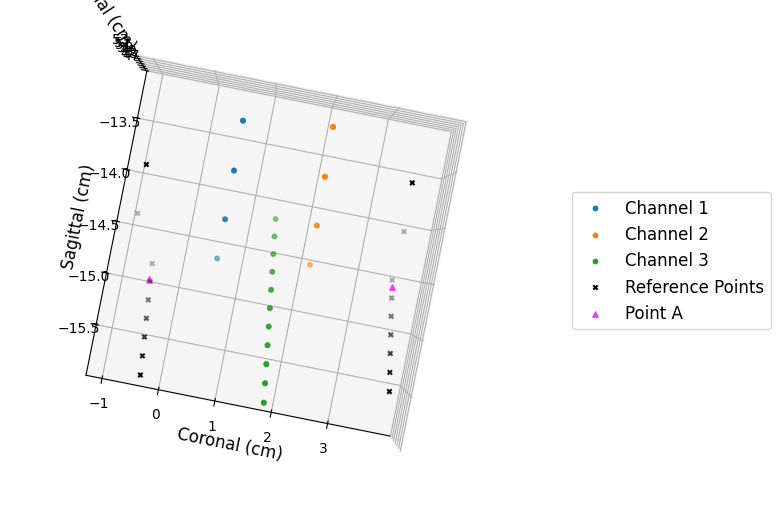

In [12]:
refs = reference_points(rt_channels)
ref_ovoid_left = refs['ref_ovoid_left']
ref_ovoid_right = refs['ref_ovoid_right']
ref_tandem_left = refs['ref_tandem_left']
ref_tandem_right = refs['ref_tandem_right']

fontsize = 12
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for channel in rt_channels:
    positions = np.array(channel.positions_cm)
    # ax.scatter(Coronal, Sagittal, Axial)
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=10, label=f'Channel {channel.channel_number}')
ax.scatter(ref_ovoid_left[:, 0], ref_ovoid_left[:, 1], ref_ovoid_left[:, 2], s=10, marker='x', color='black', label='Reference Points')
ax.scatter(ref_ovoid_right[:, 0], ref_ovoid_right[:, 1], ref_ovoid_right[:, 2], s=10, marker='x', color='black')
ax.scatter(ref_tandem_left[:, 0], ref_tandem_left[:, 1], ref_tandem_left[:, 2], s=10, marker='x', color='black')
ax.scatter(ref_tandem_right[:, 0], ref_tandem_right[:, 1], ref_tandem_right[:, 2], s=10, marker='x', color='black')

ax.scatter(pos_a_left[0], pos_a_left[1], pos_a_left[2], s=15, marker='^', color="#e745ed", label="Point A")
ax.scatter(pos_a_right[0], pos_a_right[1], pos_a_right[2], s=15, marker='^', color="#e745ed")

ax.set_xlabel('Coronal (cm)', fontsize=fontsize)
ax.set_ylabel('Sagittal (cm)', fontsize=fontsize)
ax.set_zlabel('Axial (cm)', fontsize=fontsize)

ax.view_init(elev=90, azim=-75, roll=0)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', fontsize=fontsize)
plt.tight_layout()
plt.show()

Angle between ovoid cluster and tandem axes: 90.29 deg
Approximately orthogonal within +/- 5 deg tolerance.


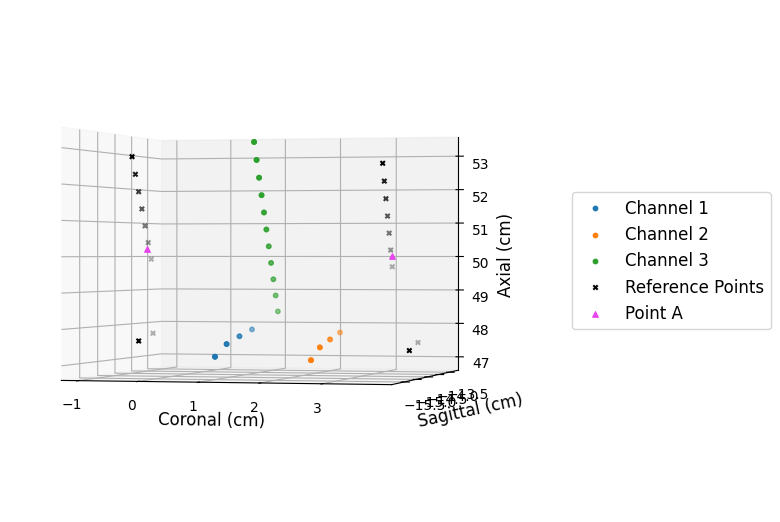

In [13]:
refs = reference_points(rt_channels)
ref_ovoid_left = refs['ref_ovoid_left']
ref_ovoid_right = refs['ref_ovoid_right']
ref_tandem_left = refs['ref_tandem_left']
ref_tandem_right = refs['ref_tandem_right']

fontsize = 12
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for channel in rt_channels:
    positions = np.array(channel.positions_cm)
    # ax.scatter(Coronal, Sagittal, Axial)
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=10, label=f'Channel {channel.channel_number}')
ax.scatter(ref_ovoid_left[:, 0], ref_ovoid_left[:, 1], ref_ovoid_left[:, 2], s=10, marker='x', color='black', label='Reference Points')
ax.scatter(ref_ovoid_right[:, 0], ref_ovoid_right[:, 1], ref_ovoid_right[:, 2], s=10, marker='x', color='black')
ax.scatter(ref_tandem_left[:, 0], ref_tandem_left[:, 1], ref_tandem_left[:, 2], s=10, marker='x', color='black')
ax.scatter(ref_tandem_right[:, 0], ref_tandem_right[:, 1], ref_tandem_right[:, 2], s=10, marker='x', color='black')

ax.scatter(pos_a_left[0], pos_a_left[1], pos_a_left[2], s=15, marker='^', color="#e745ed", label="Point A")
ax.scatter(pos_a_right[0], pos_a_right[1], pos_a_right[2], s=15, marker='^', color="#e745ed")

ax.set_xlabel('Coronal (cm)', fontsize=fontsize)
ax.set_ylabel('Sagittal (cm)', fontsize=fontsize)
ax.set_zlabel('Axial (cm)', fontsize=fontsize)

ax.view_init(elev=0, azim=-75, roll=0)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', fontsize=fontsize)
plt.tight_layout()
plt.show()